# Graph Environment Experiments (1)

In [1]:
from neuronav.envs.graph_env import GraphEnv, GraphObsType
from neuronav.envs.graph_structures import GraphStructure
from neuronav.agents.td_agents import TDSR
from neuronav.agents.dyna_agents import DynaSR
from neuronav.agents.mb_agents import MBV, SRMB
from neuronav.utils import softmax, run_episode

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_init_prefs(env, agents, num_eps, num_steps):
    init_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 1
            else:
                start_pos = 0
            agent, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        init_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))
    return init_state_prefs

def calc_revaluation(prefs_a, prefs_b):
    scores = []
    temp = 5
    for idx, pref in enumerate(prefs_a):
        a = softmax(pref[2] / temp)
        b = softmax(prefs_b[idx][2] / temp)
        score = np.abs(a - b)[0,0]
        scores.append(score)
    return scores

def plot_revaluation(scores):
    scores_mean = np.mean(scores, axis=0)
    scores_std = np.std(scores, axis=0)
    plt.axis([-1, len(scores[0]), 0, 1])
    plt.bar([name for name in agent_type_names], scores_mean, yerr=scores_std)

def init_agents(env, agent_types):
    agents = [agent_type(env.state_size, env.action_space.n, gamma=0.9, lr=1e-1, poltype=poltype, beta=beta, epsilon=epsilon) for agent_type in agent_types]
    return agents

In [3]:
def get_scores(condition_func):
    all_scores = []
    for _ in range(num_reps):
        all_scores.append(condition_func())
    all_scores = np.array(all_scores)
    plot_revaluation(all_scores)
    return all_scores

def control_func():
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    agents = init_agents(env, agent_types)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)
    control_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)
    return calc_revaluation(init_state_prefs, control_state_prefs)

def reward_func():
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    agents = init_agents(env, agent_types)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)

    env.rewarding_states[4] = 1
    env.rewarding_states[5] = 10

    rew_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 2
            else:
                start_pos = 3
            agent, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        rew_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))

    return calc_revaluation(init_state_prefs, rew_state_prefs)

def transition_func():
    env = GraphEnv(GraphStructure.human_a, obs_type=GraphObsType.index)
    agents = init_agents(env, agent_types)
    init_state_prefs = gen_init_prefs(env, agents, num_eps, num_steps)

    env.edges[2] = [5]
    env.edges[3] = [4]

    trans_state_prefs = []
    for agent in agents:
        for i in range(num_eps):
            if i % 2 == 0:
                start_pos = 2
            else:
                start_pos = 3
            agent, _ = run_episode(env, agent, num_steps, start_pos)
        Qs = agent.Q[:, :2]
        max_Q_idx = np.argmax(Qs)
        trans_state_prefs.append((agent.__class__.__name__, max_Q_idx, Qs))

    return calc_revaluation(init_state_prefs, trans_state_prefs)

In [4]:
num_eps = 100
num_steps = 3
num_reps = 10

poltype = "softmax"
beta = 1e-4
epsilon= 0.1

agent_types = [TDSR, DynaSR, SRMB, MBV]
agent_type_names = ["TDSR", "DynaSR", "SRMB", "MBV"]

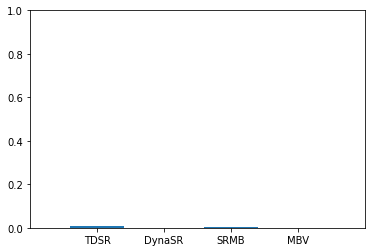

In [5]:
all_cs = get_scores(control_func)

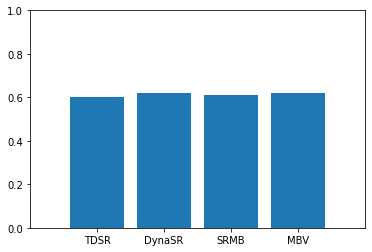

In [6]:
all_rs = get_scores(reward_func)

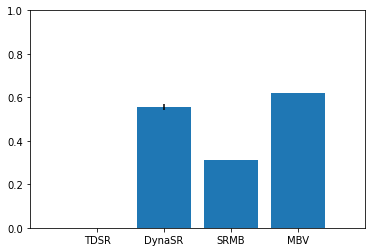

In [7]:
all_ts = get_scores(transition_func)

<ipython-input-8-d0b7df07b7cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(["Control", "Reward", "Transition"], fontsize=14)
<ipython-input-8-d0b7df07b7cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(["Control", "Reward", "Transition"], fontsize=14)
<ipython-input-8-d0b7df07b7cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(["Control", "Reward", "Transition"], fontsize=14)
<ipython-input-8-d0b7df07b7cc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(["Control", "Reward", "Transition"], fontsize=14)


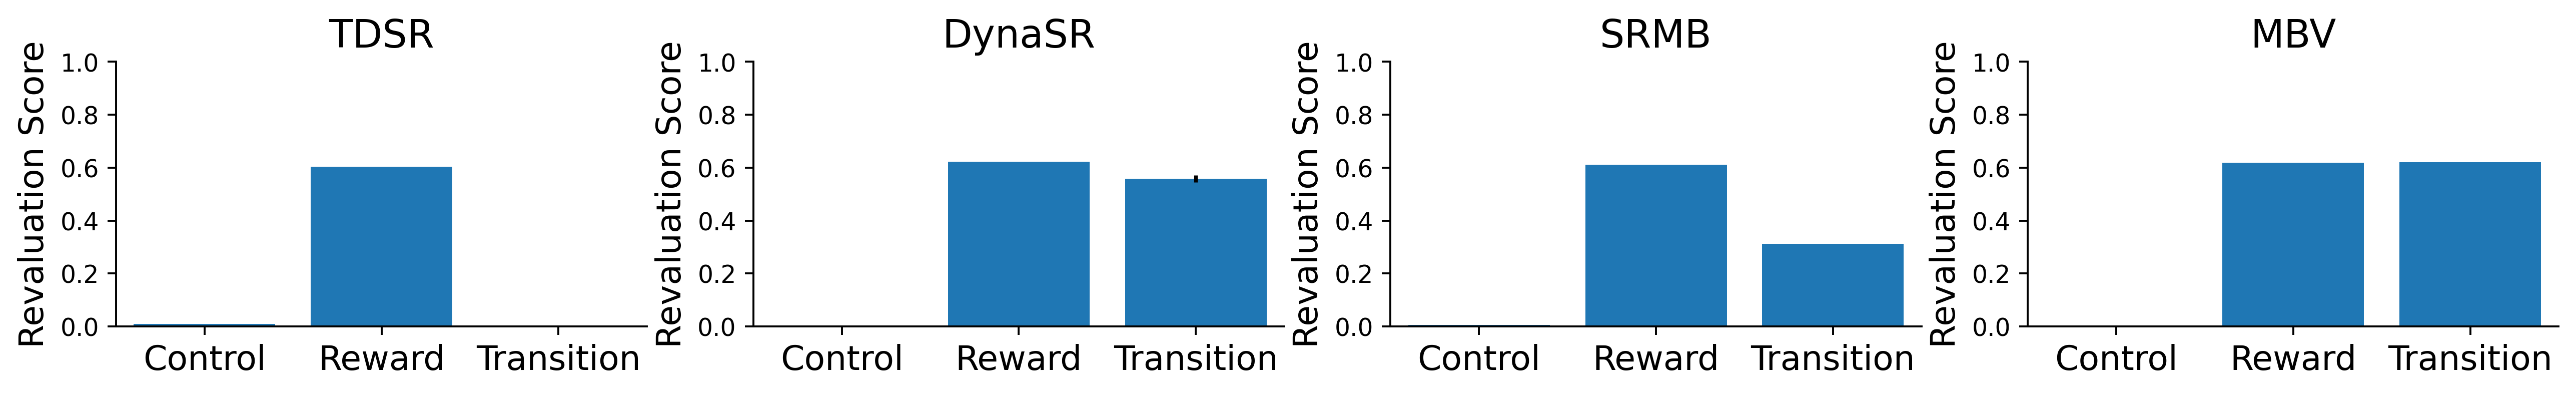

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(18, 2), dpi=(350))
for i in range(len(agent_type_names)):
    axs[i].bar(["Control", "Reward", "Transition"], [np.mean(all_cs, axis=0)[i], np.mean(all_rs, axis=0)[i], np.mean(all_ts, axis=0)[i]], yerr=[np.std(all_cs, axis=0)[i], np.std(all_rs, axis=0)[i], np.std(all_ts, axis=0)[i]])
    axs[i].axis([-.5, 2.5, 0, 1])
    axs[i].set_title(agent_type_names[i], fontsize=16)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_xticklabels(["Control", "Reward", "Transition"], fontsize=14)
    axs[i].set_ylabel("Revaluation Score", fontsize=14)
fig.savefig("exp1_result.pdf",bbox_inches='tight')